In [1]:
from calendar import error

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import os
torch.manual_seed(128)

In [2]:
model_storage_path = "model_storage"

## Task 1: Data Generation

In [3]:
def generate_sample(N, K, r=0.5):
    # Define dom D = [0,1]**2
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)

    # Init fields
    f = np.zeros((N, N))
    u = np.zeros((N, N))

    # generate a_ij (use standard normal distribution)
    a = np.random.randn(K, K)

    # Eval f, u
    for i in range(1, K + 1):
        for j in range(1, K + 1):
            a_ij = a[i-1, j-1]

            # Common terms
            sine_term = np.sin(np.pi * i * X) * np.sin(np.pi * j * Y)
            freq_sq = i**2 + j**2

            # Update u
            u += a_ij * (freq_sq**(r-1)) * sine_term

            # Update f
            f += a_ij * (freq_sq**r) * sine_term

    # Apply scaling
    u_field = (1 / (np.pi * K**2)) * u
    f_field = (np.pi / K**2) * f

    return X, Y, f_field, u_field

def plot_samples():
    """
    Plots 3 random examples for K = 1, 4, 8, 16.
    """
    N = 96
    K_values = [1, 4, 8, 16]
    num_samples = 3

    fig, axes = plt.subplots(len(K_values), 2 * num_samples, figsize=(26, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for row_idx, K in enumerate(K_values):
        for s in range(num_samples):
            # Generate data
            X, Y, f, u = generate_sample(N, K)

            # Plot Source f
            ax_f = axes[row_idx, s*2]
            im_f = ax_f.imshow(f, origin='lower', cmap='jet')
            ax_f.set_title(f'Source f (K={K})', fontsize=9)
            plt.colorbar(im_f, ax=ax_f, pad=0.1)

            # Plot Solution u
            ax_u = axes[row_idx, s*2+1]
            im_u = ax_u.imshow(u, origin='lower', cmap='jet')
            ax_u.set_title(f'Solution u (K={K})', fontsize=9)
            plt.colorbar(im_u, ax=ax_u, pad=0.1)

    plt.suptitle(f"Task 1: Data Generation (Grid {N}x{N})", fontsize=16)
    plt.show()

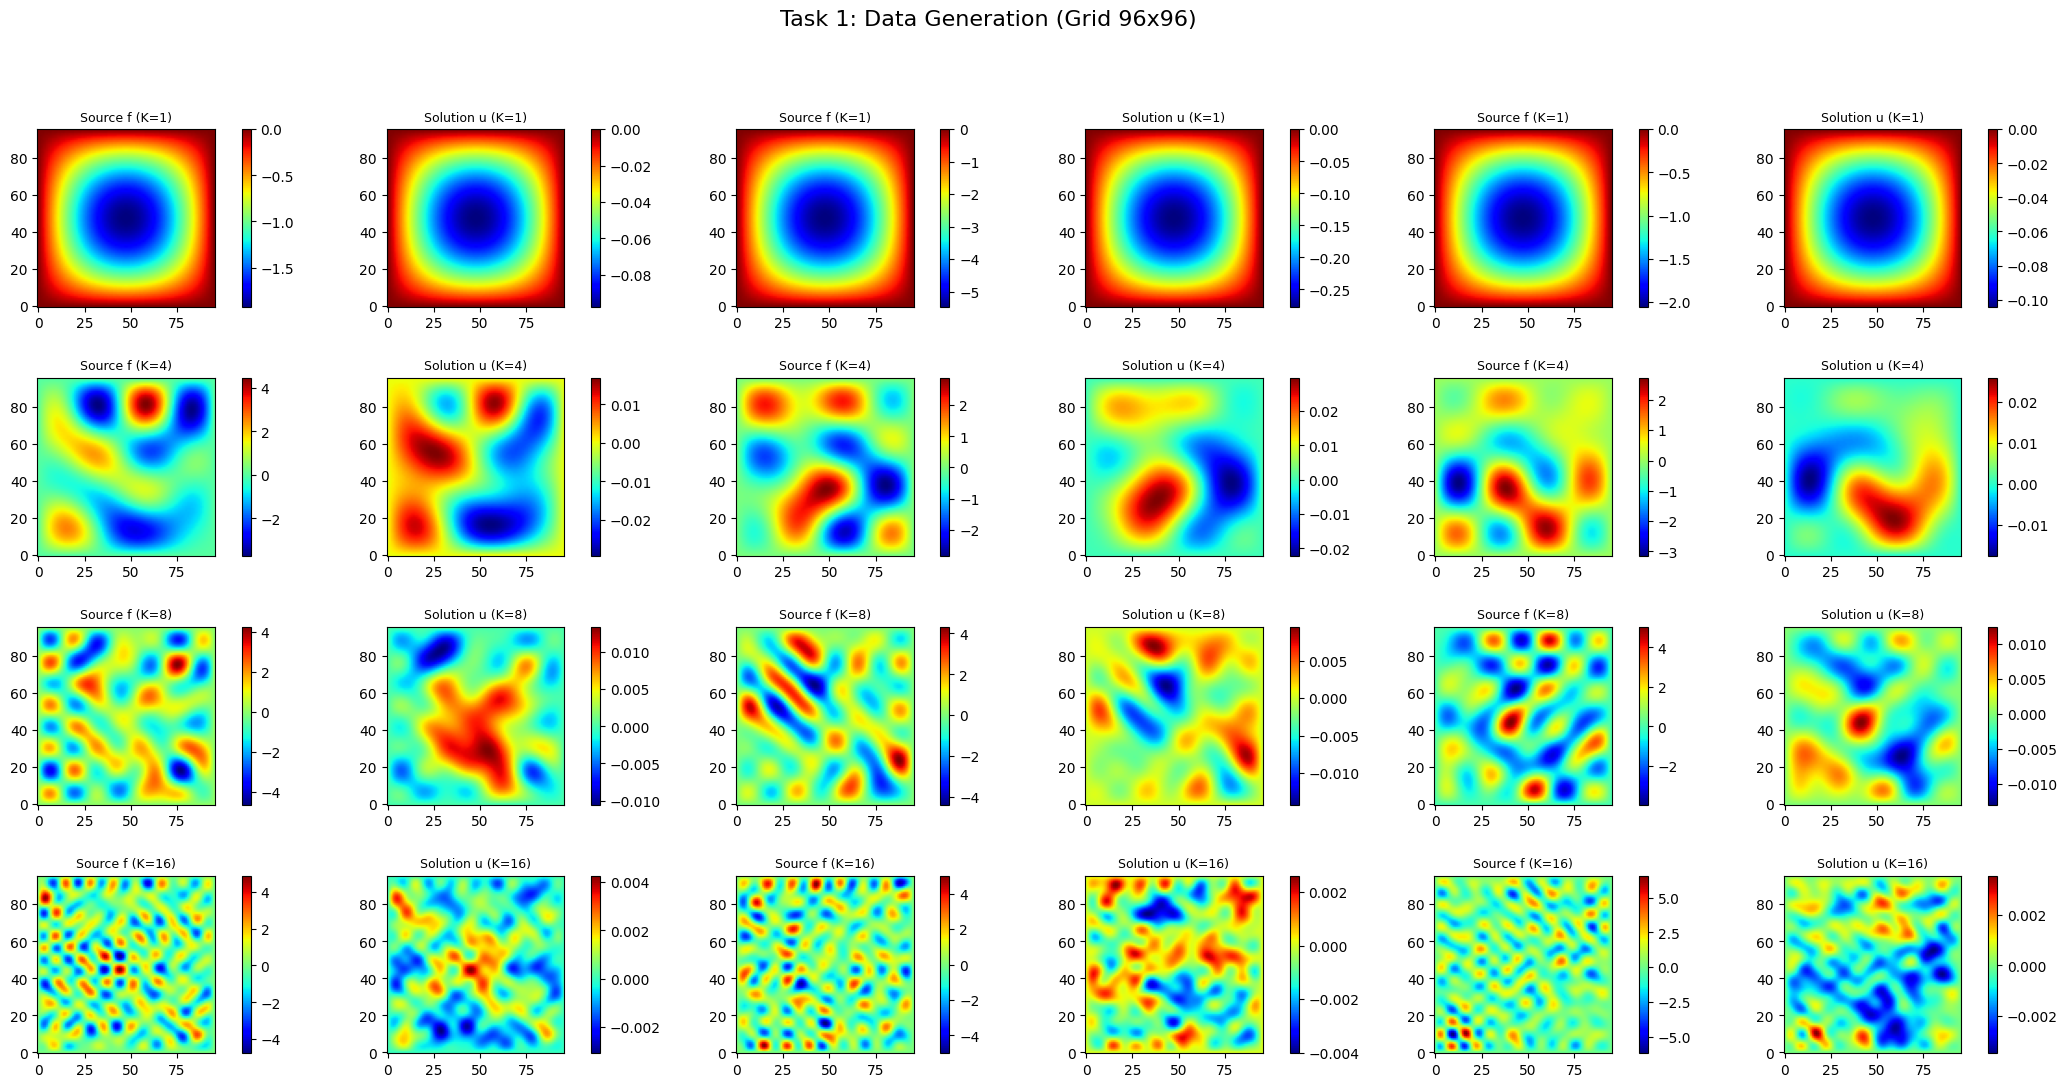

In [4]:
    plot_samples()

## Task 2: Implementation and Training

In [5]:
class NeuralNet(nn.Module):
    """ Simplified NN similar to PINN exercise """
    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_dimension, neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(neurons, neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(neurons, output_dimension)
        self.activation = nn.Tanh()

        self.init_xavier()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for l in self.hidden_layers:
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

In [6]:
class PoissonSolver:
    def __init__(self, K, mode='pinn', coefficients=None):
        """
        Depending on mode solves with pinn or data-driven loss

        :param K: spatial scales
        :param mode: 'pinn' or 'data'
        :param coefficients: (can be used to set a_ij -> consistent problem for pinn and data-driven)
        """
        self.xy_bc = None
        self.K = K
        self.mode = mode
        self.r = 0.5
        self.lambda_ = 200

        self.model = NeuralNet(input_dimension=2, output_dimension=1, n_hidden_layers=4, neurons=30)

        if coefficients is None:
            self.coefficients = torch.rand(K, K)
        else:
            self.coefficients = torch.tensor(coefficients).float()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.coefficients = self.coefficients.to(self.device)

    def evaluate_analytical(self, x, y):
        """
        Same logic as for generate_sample but using PyTorch and only returns a single sample instead of a field

        :param x:
        :param y:
        :return:
        """

        # Init fields
        f = torch.zeros_like(x)
        u = torch.zeros_like(x)

        # Eval f, u
        for i in range(1, self.K + 1):
            for j in range(1, self.K + 1):
                a_ij = self.coefficients[i-1, j-1]

                # Common terms
                sine_term = torch.sin(np.pi * i * x) * torch.sin(np.pi * j * y)
                freq_sq = i**2 + j**2

                # Update u
                u += a_ij * (freq_sq**(self.r-1)) * sine_term

                # Update f
                f += a_ij * (freq_sq**self.r) * sine_term

        # Apply scaling
        u_final = (1 / (np.pi * self.K**2)) * u
        f_final = (np.pi / self.K**2) * f

        return f_final, u_final

    # def compute_pde_residual(self, xy):
    #     xy.requires_grad = True
    #     u_pred = self.model(xy)
    #
    #     grads = torch.autograd.grad(u_pred.sum(), xy, create_graph=True)[0]
    #     u_x,u_y = grads[:, 0], grads[:, 1]
    #
    #     ones = torch.ones_like(u_x)
    #
    #     u_xx = torch.autograd.grad(u_x, xy, grad_outputs=ones, create_graph=True)[0][:, 0]
    #     u_yy = torch.autograd.grad(u_y, xy, grad_outputs=ones, create_graph=True)[0][:, 1]
    #
    #     laplacian = u_xx + u_yy
    #
    #     f_true, _ = self.evaluate_analytical(xy[:, 0], xy[:, 1])
    #
    #     return -laplacian - f_true

    def compute_laplacian(self, xy):
        xy.requires_grad = True
        u_pred = self.model(xy)

        grads = torch.autograd.grad(u_pred.sum(), xy, create_graph=True)[0]
        u_x,u_y = grads[:, 0], grads[:, 1]

        ones = torch.ones_like(u_x)

        u_xx = torch.autograd.grad(u_x, xy, grad_outputs=ones, create_graph=True)[0][:, 0]
        u_yy = torch.autograd.grad(u_y, xy, grad_outputs=ones, create_graph=True)[0][:, 1]

        laplacian = u_xx + u_yy

        return laplacian

    def train(self, epochs_adam=1000, epochs_lbfgs=500, n_samples=2000):
        # Gen training data
        # xy_train = torch.rand(n_samples, 2, device=self.device)
        N = int(np.sqrt(n_samples))
        x = torch.linspace(0, 1, N, device=self.device)
        y = torch.linspace(0, 1, N, device=self.device)
        X, Y = torch.meshgrid(x, y, indexing="ij")
        xy_train = torch.stack([X.flatten(), Y.flatten()], dim=1)

        xy_train.requires_grad = True

        # compute analytic sol
        with torch.no_grad():
            f_train_true, u_train_exact = self.evaluate_analytical(xy_train[:, 0], xy_train[:, 1])
            u_train_exact = u_train_exact.unsqueeze(1) # -> shape (N,1)

        if self.mode == 'pinn':
            # enforce u=0 at boundary
            n_bc = n_samples // 4
            bc1 = torch.rand(n_bc, 2)
            bc2 = torch.rand(n_bc, 2)
            bc3 = torch.rand(n_bc, 2)
            bc4 = torch.rand(n_bc, 2)

            bc1[:, 0] = 0.0  # x=0
            bc2[:, 0] = 1.0  # x=1
            bc3[:, 1] = 0.0  # y=0
            bc4[:, 1] = 1.0  # y=1

            corners = torch.tensor([
                [0.0, 0.0],
                [1.0, 0.0],
                [0.0, 1.0],
                [1.0, 1.0]
            ])

            xy_bc = torch.cat([bc1, bc2, bc3, bc4, corners]).to(self.device)
            xy_bc.requires_grad = False

            self.xy_bc = xy_bc

        history = []

        def loss_function():
            optimizer.zero_grad()
            loss = 0

            if self.mode == 'data':
                # MSE(pred, analytic)
                u_pred = self.model(xy_train)
                loss = torch.mean((u_pred - u_train_exact) ** 2)

            elif self.mode == 'pinn':
                # PDE Loss (Interior): | -Laplacian(u) -f|**2
                laplacian = self.compute_laplacian(xy_train)
                res = -laplacian - f_train_true
                loss_f = torch.mean(res ** 2)

                # Loss (Boundary): |u|**2
                # Points xy_bc are all on boundary. The loss on the boundary is the diff to 0
                # -> loss = mean(abs(u-0)**2) = mean(u**2)
                u_bc = self.model(xy_bc)
                loss_bc = torch.mean(u_bc ** 2)

                loss = loss_f + loss_bc*self.lambda_

            loss.backward()
            return loss

        print(f"Training {self.mode.upper()} (K={self.K})...")
        # Train with adam for the first few steps
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        for ep in range(epochs_adam):
            loss = loss_function()
            optimizer.step()
            if ep % 200 == 0:
                print(f"Epoch {ep}: Loss = {loss.item():.6f}")
            history.append(loss.item())

        # Finalize with L-BFGS
        optimizer = optim.LBFGS(self.model.parameters(),
                                lr=1.0,
                                max_iter=epochs_lbfgs,
                                history_size=50,
                                line_search_fn="strong_wolfe")

        def lbfgs_loss():
            loss = loss_function()
            history.append(loss.item())
            return loss

        optimizer.step(lbfgs_loss)
        print(f"Final Loss: {history[-1]:.6f}")
        return history


    def predict_grid(self, N=100):
        x_lin = np.linspace(0, 1, N)
        y_lin = np.linspace(0, 1, N)
        X, Y = np.meshgrid(x_lin, y_lin)

        # Flatten for model prediction
        xy_flat = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32).to(self.device)

        with torch.no_grad():
            u_pred = self.model(xy_flat).cpu().numpy().reshape(N, N)

        # Get ground truth using the SAME coefficients
        _, u_true = self.evaluate_analytical(torch.tensor(X).to(self.device),
                                             torch.tensor(Y).to(self.device))
        u_true = u_true.cpu().numpy()

        return X, Y, u_pred, u_true




Running K = 1
Training DATA (K=1)...
Epoch 0: Loss = 2.071557
Epoch 200: Loss = 0.001065
Epoch 400: Loss = 0.000345
Epoch 600: Loss = 0.000163
Epoch 800: Loss = 0.000099
Epoch 1000: Loss = 0.000074
Epoch 1200: Loss = 0.000063
Epoch 1400: Loss = 0.000057
Epoch 1600: Loss = 0.000053
Epoch 1800: Loss = 0.000049
Final Loss: 0.000002
Training PINN (K=1)...
Epoch 0: Loss = 304.956268
Epoch 200: Loss = 0.268960
Epoch 400: Loss = 0.190291
Epoch 600: Loss = 0.162926
Epoch 800: Loss = 0.141028
Epoch 1000: Loss = 0.119944
Epoch 1200: Loss = 0.100250
Epoch 1400: Loss = 0.083227
Epoch 1600: Loss = 0.069534
Epoch 1800: Loss = 0.058863
Final Loss: 0.000066
K=1 | Data Err: 1.83% | PINN Err: 0.15%
Saved PINN and DATA model to: model_storage\model_K1_data.pt

Running K = 4
Training DATA (K=4)...
Epoch 0: Loss = 2.909050
Epoch 200: Loss = 0.000550
Epoch 400: Loss = 0.000249
Epoch 600: Loss = 0.000174
Epoch 800: Loss = 0.000136
Epoch 1000: Loss = 0.000111
Epoch 1200: Loss = 0.000094
Epoch 1400: Loss = 0.

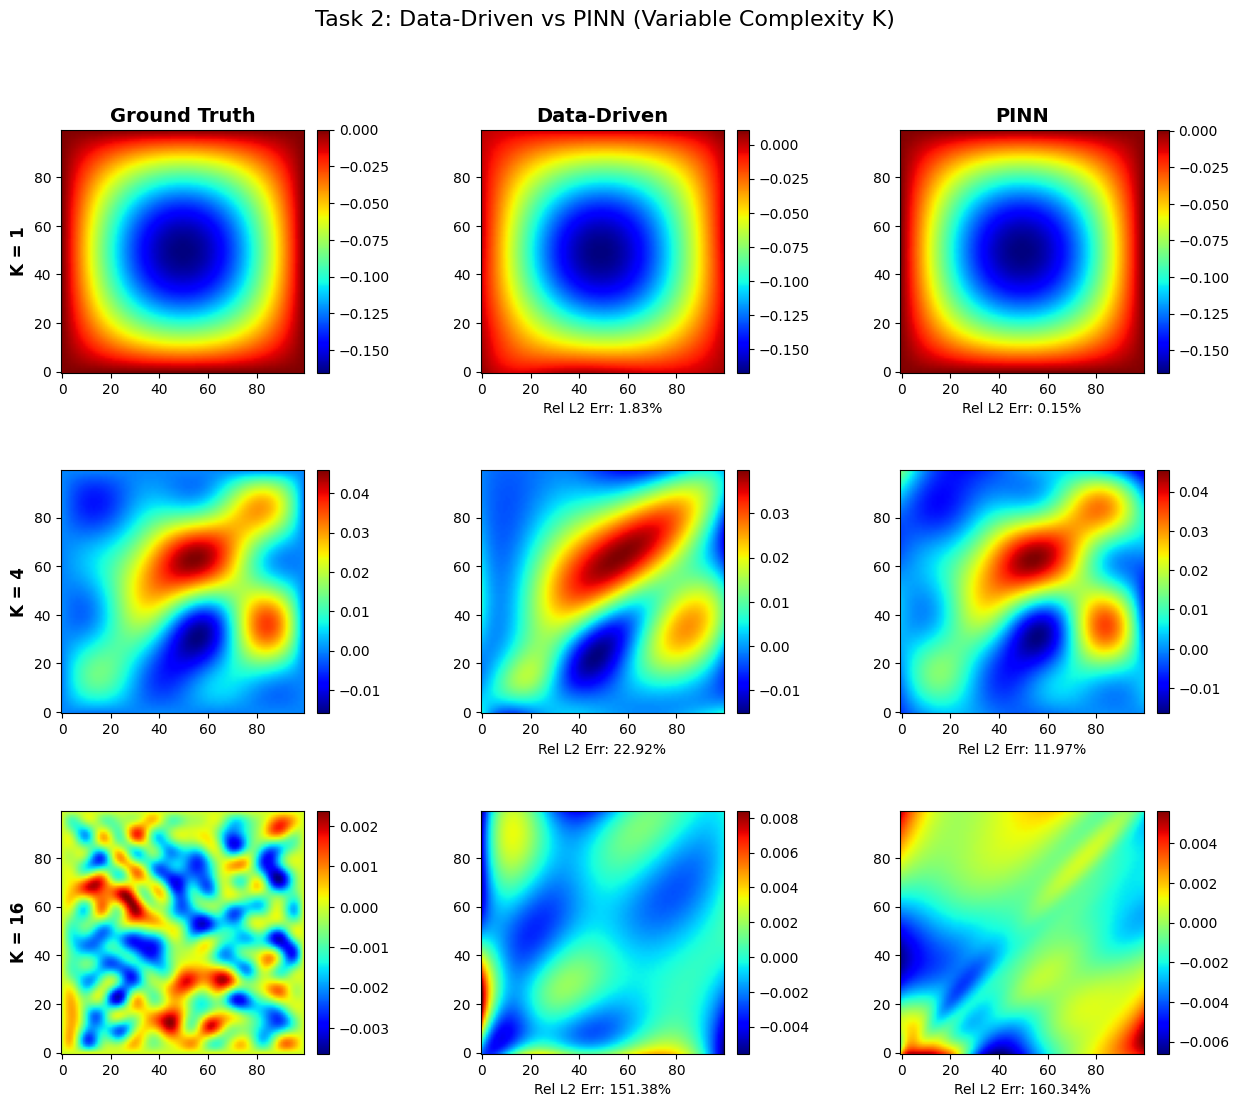

In [7]:
K_values = [1, 4, 16]

fig, axes = plt.subplots(len(K_values), 3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Headers
cols = ["Ground Truth", "Data-Driven", "PINN"]
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=14, fontweight='bold')

for idx, K in enumerate(K_values):
    print(f"\nRunning K = {K}")

    # Generate Coefficients ONCE -> both solvers see same problem
    coefficients = np.random.randn(K, K)

    # Train Data-Driven
    solver_data = PoissonSolver(K=K, mode='data', coefficients=coefficients)
    loss_history_data = solver_data.train(epochs_adam=2000, epochs_lbfgs=1000)

    # Train PINN
    solver_pinn = PoissonSolver(K=K, mode='pinn', coefficients=coefficients)
    loss_history_pinn = solver_pinn.train(epochs_adam=2000, epochs_lbfgs=500)

    # Predict + Compare
    _, _, u_pred_data, u_true = solver_data.predict_grid()
    _, _, u_pred_pinn, _ = solver_pinn.predict_grid()

    # Calculate Errors
    err_data = np.linalg.norm(u_true - u_pred_data) / np.linalg.norm(u_true)
    err_pinn = np.linalg.norm(u_true - u_pred_pinn) / np.linalg.norm(u_true)

    print(f"K={K} | Data Err: {err_data:.2%} | PINN Err: {err_pinn:.2%}")

    # save PINN
    save_path = os.path.join(model_storage_path, f"model_K{K}_pinn.pt")
    torch.save({
        "K": K,
        "mode": solver_pinn.mode,
        "model_state_dict": solver_pinn.model.state_dict(),
        "coefficients": coefficients,
        "error": err_pinn,
        "loss_history": loss_history_pinn,
        "xy_bc": solver_pinn.xy_bc,
    }, save_path)

    # save DATA-driven
    save_path = os.path.join(model_storage_path, f"model_K{K}_data.pt")
    torch.save({
        "K": K,
        "mode": solver_data.mode,
        "model_state_dict": solver_data.model.state_dict(),
        "coefficients": coefficients,
        "error": err_data,
        "loss_history": loss_history_data,
    }, save_path)

    print(f"Saved PINN and DATA model to: {save_path}")

    # Plotting
    # Ground Truth
    im0 = axes[idx, 0].imshow(u_true, origin='lower', cmap='jet')
    axes[idx, 0].set_ylabel(f"K = {K}", fontsize=12, fontweight='bold')
    plt.colorbar(im0, ax=axes[idx, 0], pad=0.04)

    # Data-Driven
    im1 = axes[idx, 1].imshow(u_pred_data, origin='lower', cmap='jet')
    axes[idx, 1].set_xlabel(f"Rel L2 Err: {err_data:.2%}")
    plt.colorbar(im1, ax=axes[idx, 1], pad=0.04)

    # PINN
    im2 = axes[idx, 2].imshow(u_pred_pinn, origin='lower', cmap='jet')
    axes[idx, 2].set_xlabel(f"Rel L2 Err: {err_pinn:.2%}")
    plt.colorbar(im2, ax=axes[idx, 2], pad=0.04)

plt.suptitle("Task 2: Data-Driven vs PINN (Variable Complexity K)", fontsize=16)
plt.show()

## Task 3: Loss Landscape Visualization

In [21]:
def get_concatenated_params(model):
    vectors = []
    for param in model.parameters():
        vectors.append(param.data.view(-1).cpu())
    return torch.cat(vectors)

def reset_params_vectors(model, vector):
    pointer = 0
    for param in model.parameters():
        num_param = param.numel()
        param.data.copy_(vector[pointer:pointer + num_param].view_as(param).to(param.device))
        pointer += num_param

def get_random_directions(model):
    """ generate two random directions (delta, eta) normalized, filter-wise """
    delta = []
    eta = []

    for param in model.parameters():
        d = torch.randn_like(param)
        e = torch.randn_like(param)

        if len(param.shape) >= 2:
            param_norm = param.data.norm(dim=1, keepdim=True)
            d_norm = d.norm(dim=1, keepdim=True)
            e_norm = e.norm(dim=1, keepdim=True)

            d = d * (param_norm / (d_norm + 1e-10))
            e = e * (param_norm / (e_norm + 1e-10))

        else:
            param_norm = param.data.norm()
            d = d * (param_norm / (d.norm() + 1e-10))
            e = e * (param_norm / (e.norm() + 1e-10))

        delta.append(d.view(-1).cpu())
        eta.append(e.view(-1).cpu())

    return torch.cat(delta), torch.cat(eta)


In [22]:
def compute_loss_landscape(model, loss, grid_size=21, scale=1.0):

    model.eval()
    delta, eta = get_random_directions(model)

    alphas = np.linspace(-scale, scale, grid_size)
    betas = np.linspace(-scale, scale, grid_size)
    ALPHA, BETA = np.meshgrid(alphas, betas)
    losses = np.zeros_like(ALPHA)

    original_params = get_concatenated_params(model)

    for i in range(grid_size):
        for j in range(grid_size):
            perturbation = alphas[i] * delta + betas[j]*eta
            reset_params_vectors(model, original_params+perturbation)

            with torch.no_grad():
                losses[j, i] = loss(track_grad=False).item()

    reset_params_vectors(model, original_params)
    return ALPHA, BETA, losses



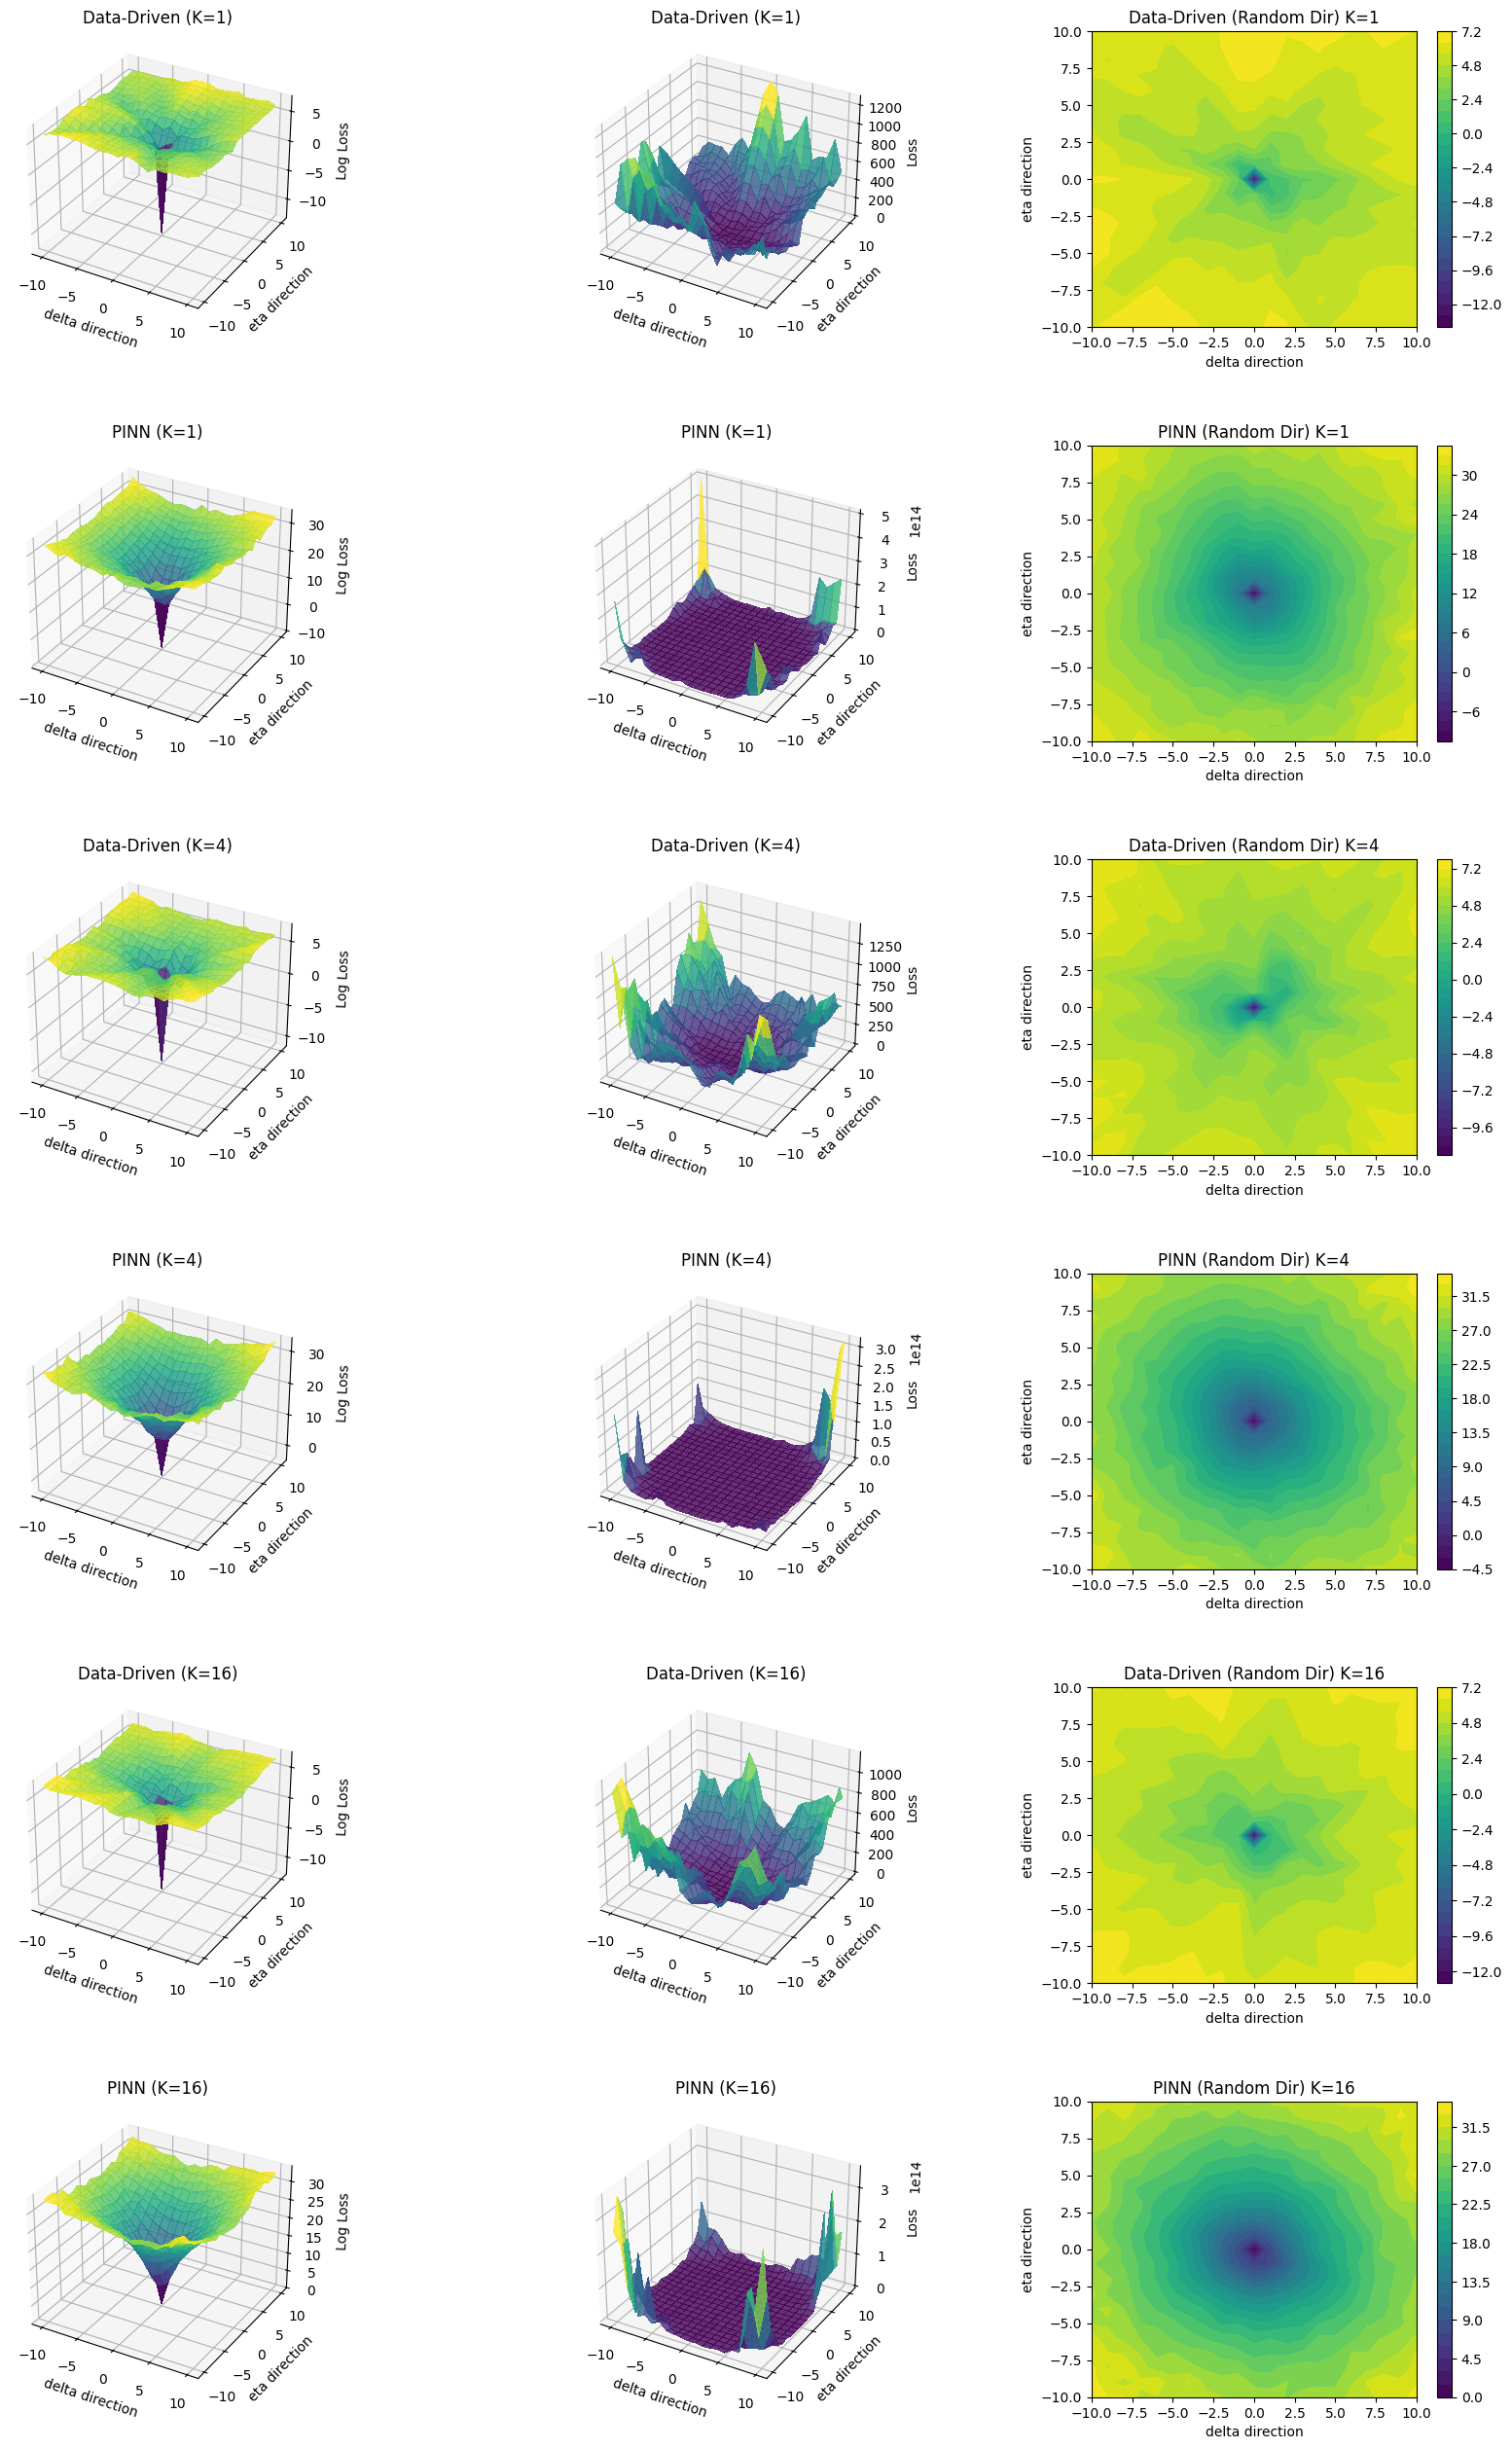

In [71]:
fig = plt.figure(figsize=(16, 25))
plot_idx = 1
K_values = [1, 4, 16]

N = int(np.sqrt(2000))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.linspace(0, 1, N, device=device)
y = torch.linspace(0, 1, N, device=device)
X, Y = torch.meshgrid(x, y, indexing="ij")
xy_train = torch.stack([X.flatten(), Y.flatten()], dim=1)


for K in K_values:

    path_data = os.path.join(model_storage_path, f"model_K{K}_data.pt")
    checkpoint = torch.load(path_data, weights_only=False)

    solver_data = PoissonSolver(K=K, mode='data', coefficients=checkpoint['coefficients'])
    solver_data.model.load_state_dict(checkpoint['model_state_dict'])

    f_train_true, u_train_exact = solver_data.evaluate_analytical(xy_train[:, 0], xy_train[:, 1])
    u_train_exact = u_train_exact.to(device)

    def loss_data(track_grad=False):
        u_pred = solver_data.model(xy_train)
        return torch.mean((u_pred - u_train_exact.unsqueeze(1)) ** 2)

    X, Y, Z = compute_loss_landscape(solver_data.model, loss_data, scale=10)

    ax = fig.add_subplot(6, 3, plot_idx, projection='3d')
    surf = ax.plot_surface(X, Y, np.log(Z + 1e-10), cmap="viridis",
                           linewidth=0, antialiased=False, alpha=0.8)
    ax.set_title(f"Data-Driven (K={K})")
    ax.set_xlabel('delta direction')
    ax.set_ylabel('eta direction')
    ax.set_zlabel('Log Loss')
    plot_idx += 1

    ax = fig.add_subplot(6, 3, plot_idx, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap="viridis",
                           linewidth=0, antialiased=False, alpha=0.8)
    ax.set_title(f"Data-Driven (K={K})")
    ax.set_xlabel('delta direction')
    ax.set_ylabel('eta direction')
    ax.set_zlabel('Loss', rotation=90)
    plot_idx += 1

    ax = fig.add_subplot(6, 3, plot_idx)
    cp = ax.contourf(X, Y, np.log(Z + 1e-10), levels=30, cmap='viridis')
    ax.set_title(f"Data-Driven (Random Dir) K={K}")
    plt.colorbar(cp, ax=ax)
    plot_idx += 1
    ax.set_xlabel('delta direction')
    ax.set_ylabel('eta direction')

    # ---------------------------------------------------------
    # PINN PLOT

    path_pinn = os.path.join(model_storage_path, f"model_K{K}_pinn.pt")
    checkpoint_pinn = torch.load(path_pinn, weights_only=False)

    solver_pinn = PoissonSolver(K=K, mode='pinn', coefficients=checkpoint_pinn['coefficients'])
    solver_pinn.model.load_state_dict(checkpoint_pinn['model_state_dict'])

    if "xy_bc" in checkpoint_pinn:
        xy_bc = checkpoint_pinn["xy_bc"].to(device)
    else:
        raise error

    f_train_pinn, _ = solver_pinn.evaluate_analytical(xy_train[:, 0], xy_train[:, 1])

    def loss_pinn(track_grad=False):
        with torch.enable_grad():
            xy_train.requires_grad = True
            laplacian = solver_pinn.compute_laplacian(xy_train)
            res = -laplacian - f_train_pinn
            loss_f = torch.mean(res ** 2)

            u_bc = solver_pinn.model(xy_bc)
            loss_bc = torch.mean(u_bc ** 2)
        return loss_f + solver_pinn.lambda_ * loss_bc

    X_p, Y_p, Z_p = compute_loss_landscape(solver_pinn.model, loss_pinn, scale=10)

    ax = fig.add_subplot(6, 3, plot_idx, projection='3d')
    surf = ax.plot_surface(X_p, Y_p, np.log(Z_p + 1e-10), cmap='viridis',
                           linewidth=0, antialiased=False, alpha=0.8)
    ax.set_title(f"PINN (K={K})")
    ax.set_xlabel('delta direction')
    ax.set_ylabel('eta direction')
    ax.set_zlabel('Log Loss')
    plot_idx += 1

    ax = fig.add_subplot(6, 3, plot_idx, projection='3d')
    surf = ax.plot_surface(X_p, Y_p, Z_p, cmap='viridis',
                           linewidth=0, antialiased=False, alpha=0.8)
    ax.set_title(f"PINN (K={K})")
    ax.set_xlabel('delta direction')
    ax.set_ylabel('eta direction')
    ax.set_zlabel('Loss', rotation=90)
    plot_idx += 1


    ax = fig.add_subplot(6, 3, plot_idx)
    cp = ax.contourf(X_p, Y_p, np.log(Z_p + 1e-10), levels=30, cmap='viridis')
    ax.set_title(f"PINN (Random Dir) K={K}")
    plt.colorbar(cp, ax=ax)
    plot_idx += 1
    ax.set_xlabel('delta direction')
    ax.set_ylabel('eta direction')

plt.tight_layout(pad=0.1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)